In [1]:
pip install tonic

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tonic
import tonic.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

In [3]:

trainset = tonic.datasets.SHD(save_to="./data", train=True)
testset = tonic.datasets.SHD(save_to="./data", train=False)

print(f"Train size: {len(trainset)} samples")
print(f"Test size: {len(testset)} samples")

Train size: 8156 samples
Test size: 2264 samples


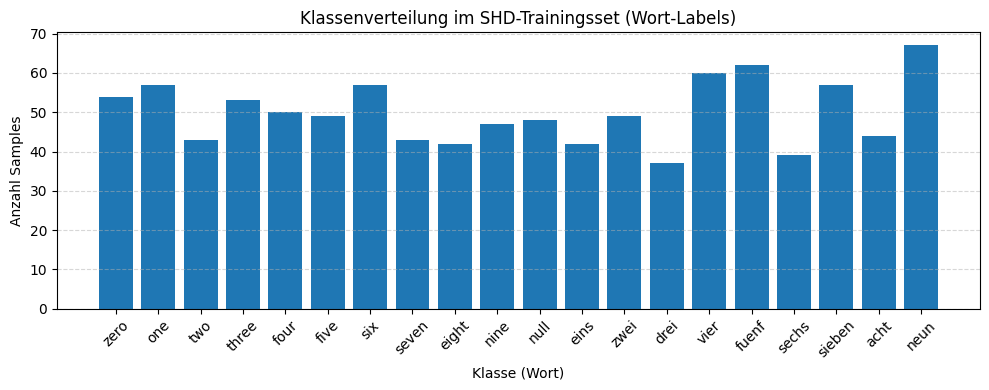

In [4]:
# Temporär: Datensatz ohne Transform laden – viel schneller

labels = [trainset[i][1] for i in range(1000)]
label_counts = np.bincount(labels)

index_to_word = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
    10: "null",
    11: "eins",
    12: "zwei",
    13: "drei",
    14: "vier",
    15: "fuenf",
    16: "sechs",
    17: "sieben",
    18: "acht",
    19: "neun"
}





# Plot
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(label_counts)), label_counts)
x_labels = [index_to_word[i] for i in range(len(label_counts))]
plt.xticks(ticks=np.arange(len(label_counts)), labels=x_labels, rotation=45)
plt.xlabel("Klasse (Wort)")
plt.ylabel("Anzahl Samples")
plt.title("Klassenverteilung im SHD-Trainingsset (Wort-Labels)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


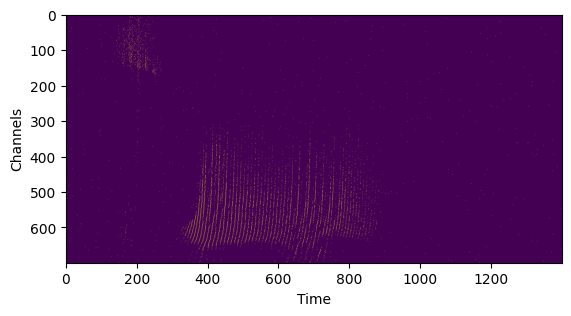

In [5]:
audio_events,label=trainset[15]
tonic.utils.plot_event_grid(audio_events, axis_array=(1, 5))


In [6]:
audio_events

array([(     0, 180, 0), (  1416, 461, 0), (  3124, 239, 0), ...,
       (798339, 656, 0), (799316, 468, 0), (799316,  22, 0)],
      dtype=[('t', '<i8'), ('x', '<i8'), ('p', '<i8')])

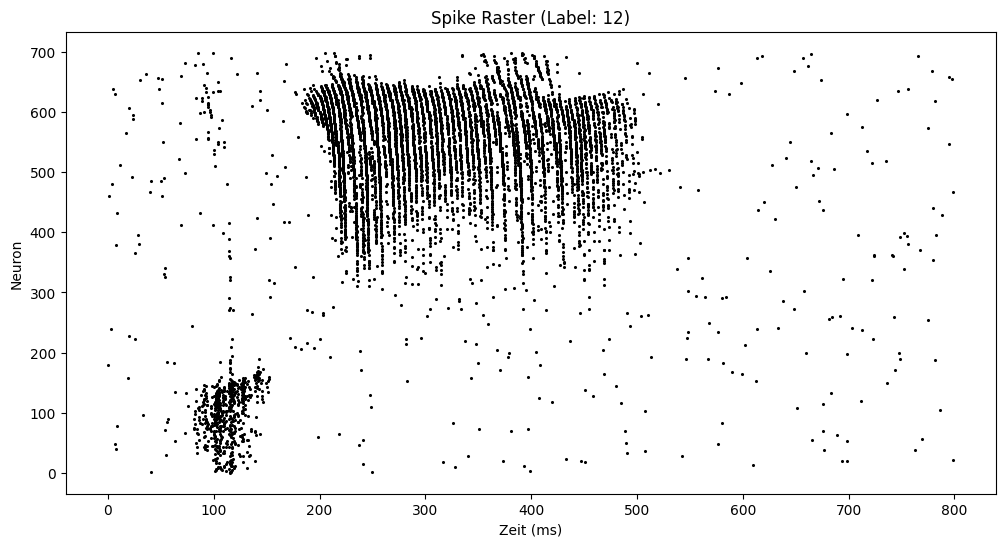

In [7]:
import snntorch.spikeplot as splt
import torch
import matplotlib.pyplot as plt

# Nehme audio_events direkt
audio_events["t"] = audio_events["t"] // 1000  # Mikrosekunden → Millisekunden

# Dynamisch maximale Werte bestimmen
neurons = audio_events["x"].max() + 1
timesteps = audio_events["t"].max() + 1

# Spiketrain-Tensor erzeugen
spike_tensor = torch.zeros((timesteps, neurons), dtype=torch.float32)

# Spikes eintragen
for x, t in zip(audio_events["x"], audio_events["t"]):
    spike_tensor[t, x] = 1

# Plotten
fig, ax = plt.subplots(figsize=(12, 6))
splt.raster(spike_tensor, ax, s=1.5, c="black")
ax.set_title(f"Spike Raster (Label: {label})")
ax.set_xlabel("Zeit (ms)")
ax.set_ylabel("Neuron")
plt.show()


In [8]:
audio_events

array([(  0, 180, 0), (  1, 461, 0), (  3, 239, 0), ..., (798, 656, 0),
       (799, 468, 0), (799,  22, 0)],
      dtype=[('t', '<i8'), ('x', '<i8'), ('p', '<i8')])

In [9]:
num_spikes = spike_tensor.sum().item()

In [10]:
num_spikes

7549.0

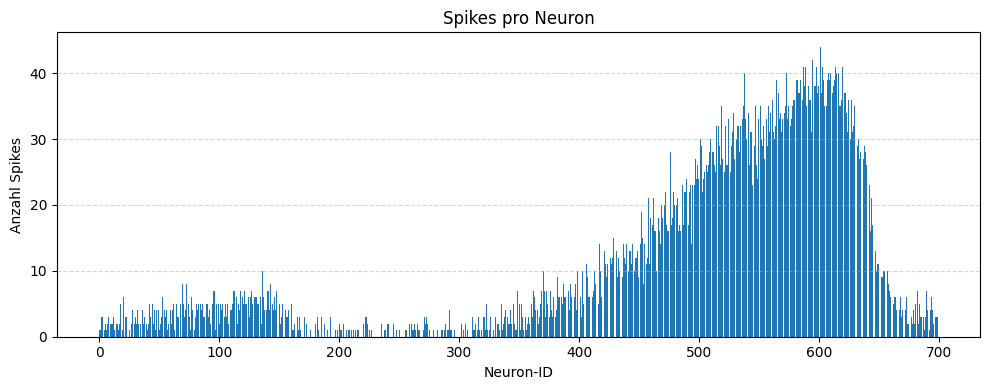

In [11]:
spikes_per_neuron = spike_tensor.sum(dim=0)  # [Zeit, Neuron] → summe über Zeit

plt.figure(figsize=(10, 4))
plt.bar(torch.arange(len(spikes_per_neuron)), spikes_per_neuron)
plt.xlabel("Neuron-ID")
plt.ylabel("Anzahl Spikes")
plt.title("Spikes pro Neuron")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


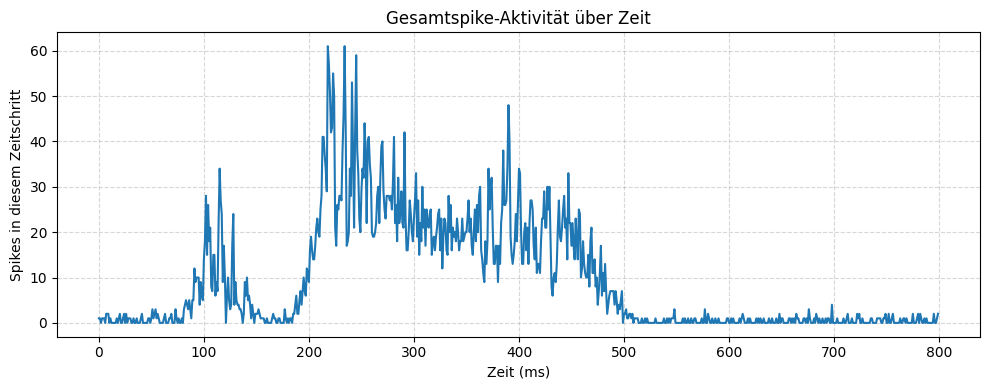

In [12]:
spikes_per_time = spike_tensor.sum(dim=1)  # [Zeit, Neuron] → summe über Neuronen

plt.figure(figsize=(10, 4))
plt.plot(spikes_per_time)
plt.xlabel("Zeit (ms)")
plt.ylabel("Spikes in diesem Zeitschritt")
plt.title("Gesamtspike-Aktivität über Zeit")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


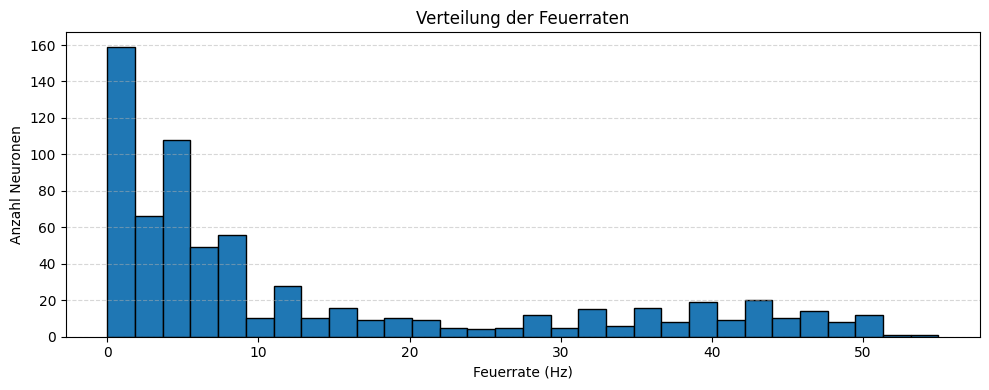

In [13]:
timesteps = spike_tensor.shape[0]  # weil Form [Zeit, Neuron]
duration_s = timesteps / 1000  # wenn 1 ms = 1 Timestep → Sekunden

firing_rates = spikes_per_neuron / duration_s  # in Hz

plt.figure(figsize=(10, 4))
plt.hist(firing_rates.numpy(), bins=30, edgecolor='black')
plt.xlabel("Feuerrate (Hz)")
plt.ylabel("Anzahl Neuronen")
plt.title("Verteilung der Feuerraten")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
import tonic
import torch
import matplotlib.pyplot as plt

# SHD-Datensatz laden
dataset = tonic.datasets.SHD(save_to="./data", train=True, transform=None)

# Ziel-Label festlegen
target_label = 9  # z. B. "nine"

# Initialisierung
all_spike_tensors = []
max_x = 0
max_t = 0

# Über die ersten 1000 Samples iterieren
for i in range(1000):
    events, label = dataset[i]

    if label != target_label:
        continue  # nur gewünschtes Label verarbeiten

    # Zeit in Millisekunden (int)
    t_ms = events["t"] // 1000

    # Tensorgröße bestimmen
    x_max = events["x"].max() + 1
    t_max = t_ms.max() + 1

    # Tracken für spätere Normalisierung
    max_x = max(max_x, x_max)
    max_t = max(max_t, t_max)

    # Leerer Spike-Tensor [t, x]
    spike_tensor = torch.zeros((t_max, x_max), dtype=torch.float32)

    for x, t in zip(events["x"], t_ms):
        spike_tensor[t, x] = 1

    all_spike_tensors.append(spike_tensor)

print(f"{len(all_spike_tensors)} Samples mit Label {target_label} gefunden")


47 Samples mit Label 9 gefunden


In [15]:
audio_events

array([(  0, 180, 0), (  1, 461, 0), (  3, 239, 0), ..., (798, 656, 0),
       (799, 468, 0), (799,  22, 0)],
      dtype=[('t', '<i8'), ('x', '<i8'), ('p', '<i8')])

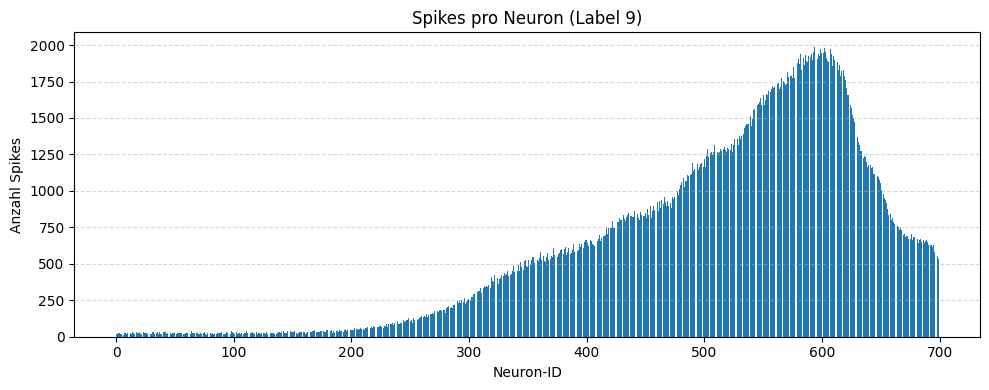

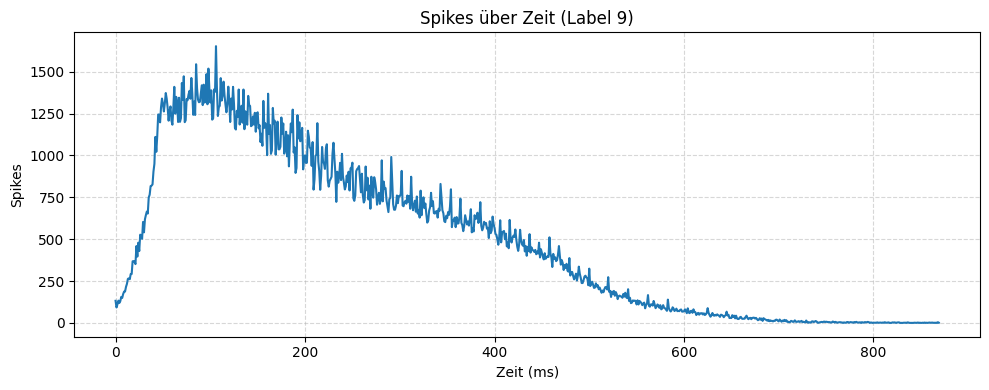

In [16]:
# Ein großes Tensorfeld initialisieren
summed_tensor = torch.zeros((max_t, max_x))

# Alles auf gleiche Größe bringen und aufsummieren
for s in all_spike_tensors:
    padded = torch.zeros((max_t, max_x))
    padded[:s.shape[0], :s.shape[1]] = s
    summed_tensor += padded

# Jetzt kannst du wie vorher analysieren:
spikes_per_neuron = summed_tensor.sum(dim=0)
spikes_per_time = summed_tensor.sum(dim=1)

# Plot: Spikes pro Neuron
plt.figure(figsize=(10, 4))
plt.bar(torch.arange(max_x), spikes_per_neuron)
plt.xlabel("Neuron-ID")
plt.ylabel("Anzahl Spikes")
plt.title(f"Spikes pro Neuron (Label {target_label})")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot: Spikes über Zeit
plt.figure(figsize=(10, 4))
plt.plot(spikes_per_time)
plt.xlabel("Zeit (ms)")
plt.ylabel("Spikes")
plt.title(f"Spikes über Zeit (Label {target_label})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [17]:
def analyze_shd_all_classes(dataset, N=1000, time_bin_us=1000, plot=True):
    from collections import defaultdict
    import torch
    import matplotlib.pyplot as plt

    print(f"🔍 Analyse der ersten {N} Samples ...")

    raw_tensors = defaultdict(list)
    max_x, max_t = 0, 0

    # 1. Alle Events in ungepaddeter Form sammeln
    for i in range(N):
        events, label = dataset[i]

        t_binned = events["t"] // time_bin_us
        x = events["x"]

        t_max = t_binned.max() + 1
        x_max = x.max() + 1
        max_t = max(max_t, t_max)
        max_x = max(max_x, x_max)

        spike_tensor = torch.zeros((t_max, x_max))
        for x_val, t_val in zip(x, t_binned):
            spike_tensor[t_val, x_val] = 1

        raw_tensors[label].append(spike_tensor)

    # 2. Auf globales Maß padden und aufsummieren
    summed_tensors = {}
    for label, tensor_list in raw_tensors.items():
        sum_tensor = torch.zeros((max_t, max_x))
        for tensor in tensor_list:
            padded = torch.zeros((max_t, max_x))
            padded[:tensor.shape[0], :tensor.shape[1]] = tensor
            sum_tensor += padded
        summed_tensors[label] = sum_tensor

    print(f"✅ Verarbeitung abgeschlossen. {len(summed_tensors)} Klassen gefunden.\n")

    # 3. Optional Plot
    if plot:
        index_to_word = {
            0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
            5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine",
            10: "null", 11: "eins", 12: "zwei", 13: "drei", 14: "vier",
            15: "fuenf", 16: "sechs", 17: "sieben", 18: "acht", 19: "neun"
        }

        for label in sorted(summed_tensors.keys()):
            tensor = summed_tensors[label]
            spikes_per_neuron = tensor.sum(dim=0)
            spikes_per_time = tensor.sum(dim=1)

            # Spikes pro Neuron
            plt.figure(figsize=(10, 3))
            plt.bar(torch.arange(len(spikes_per_neuron)), spikes_per_neuron)
            plt.title(f"Spikes pro Neuron – Klasse {label}: {index_to_word.get(label, str(label))}")
            plt.xlabel("Neuron-ID")
            plt.ylabel("Spikes")
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

            # Spikes über Zeit
            plt.figure(figsize=(10, 3))
            plt.plot(spikes_per_time)
            plt.title(f"Spikes über Zeit – Klasse {label}: {index_to_word.get(label, str(label))}")
            plt.xlabel("Zeit (ms)")
            plt.ylabel("Spikes")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    return summed_tensors


🔍 Analyse der ersten 1000 Samples ...
✅ Verarbeitung abgeschlossen. 20 Klassen gefunden.



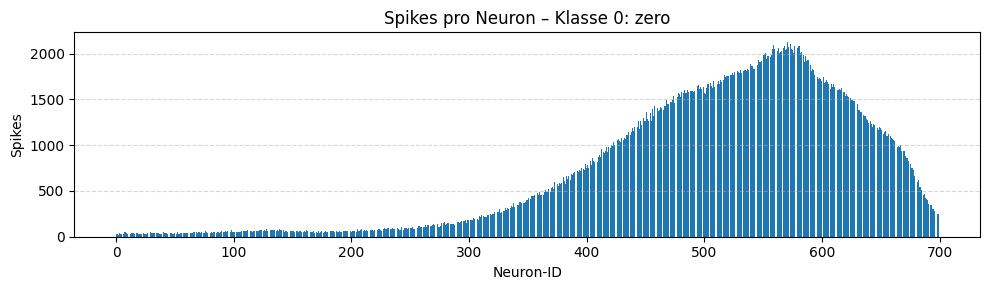

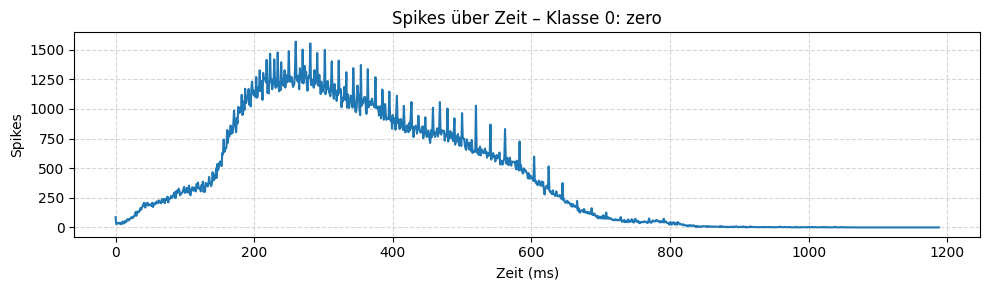

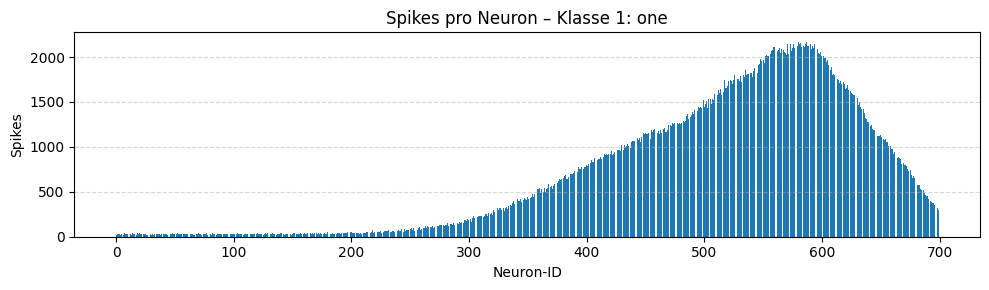

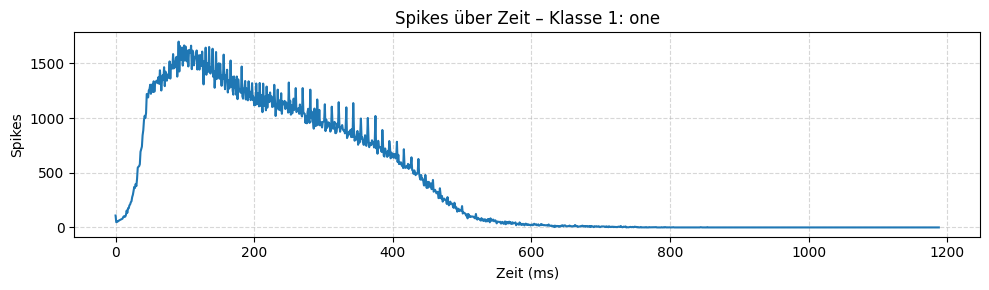

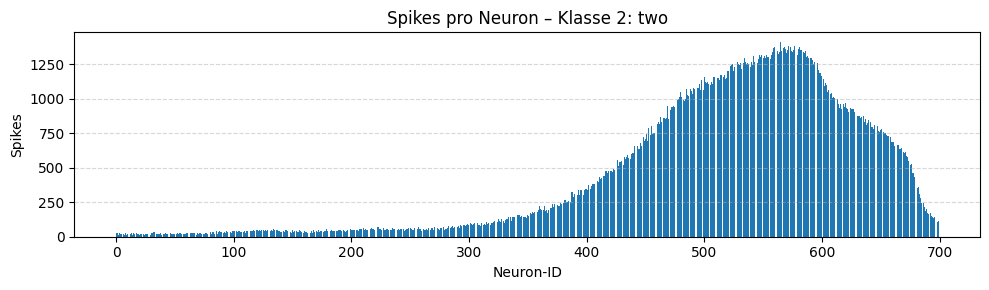

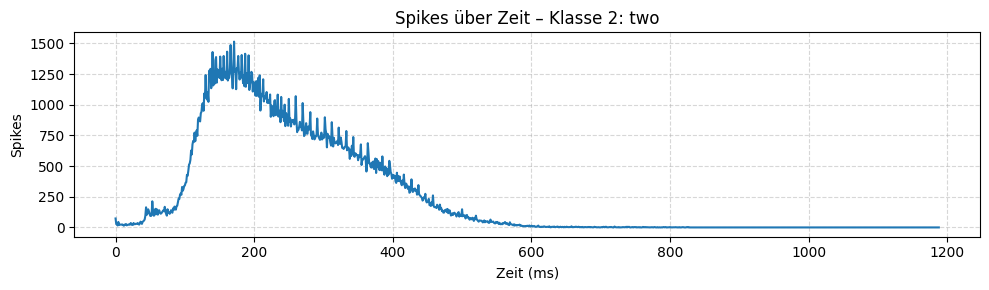

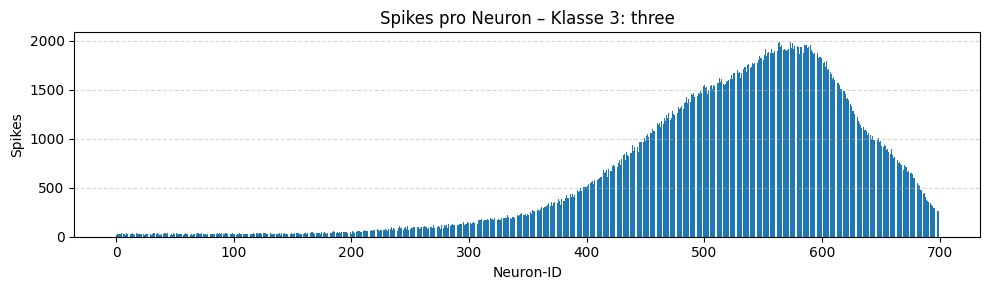

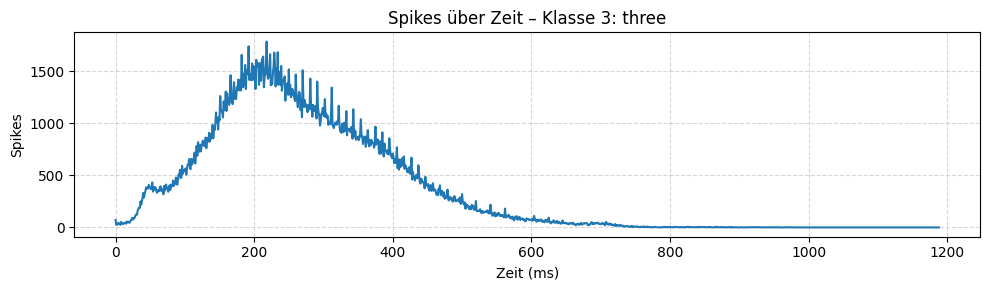

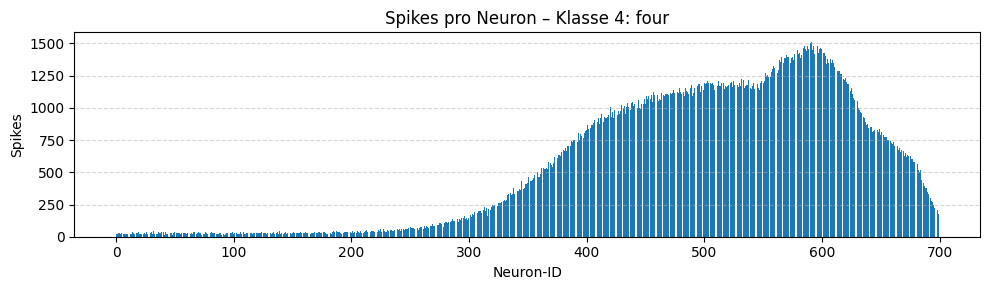

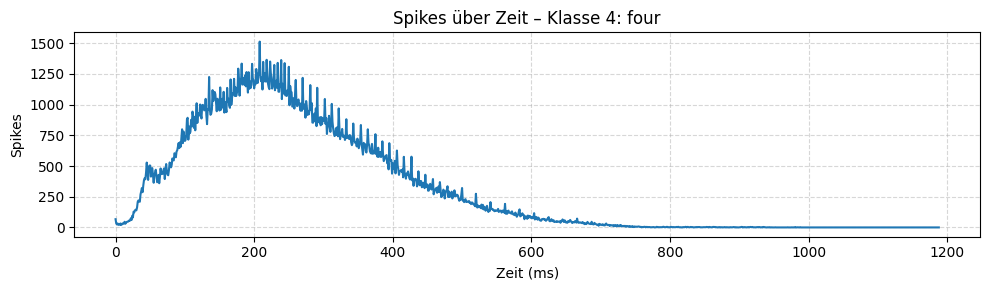

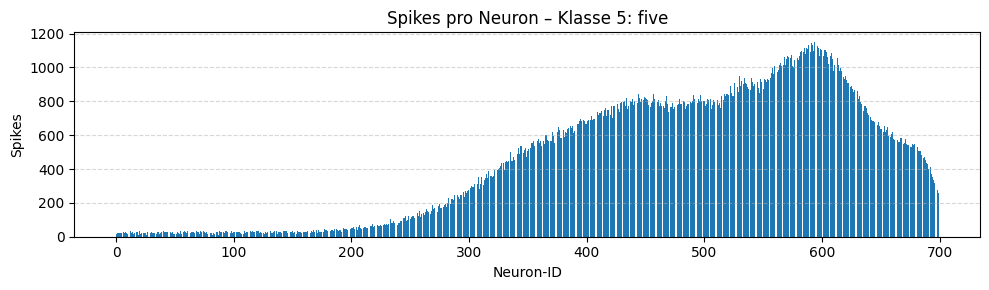

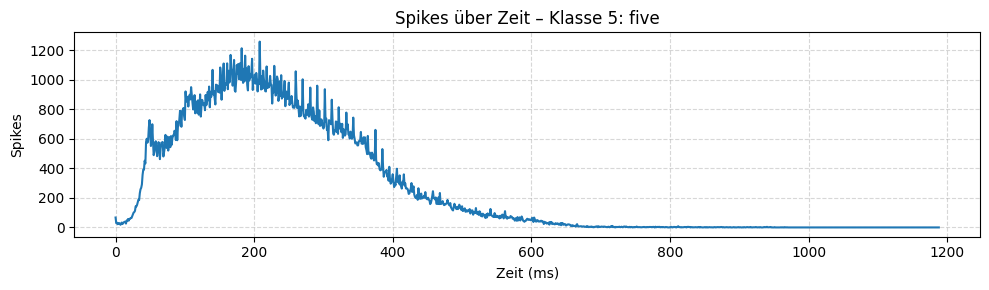

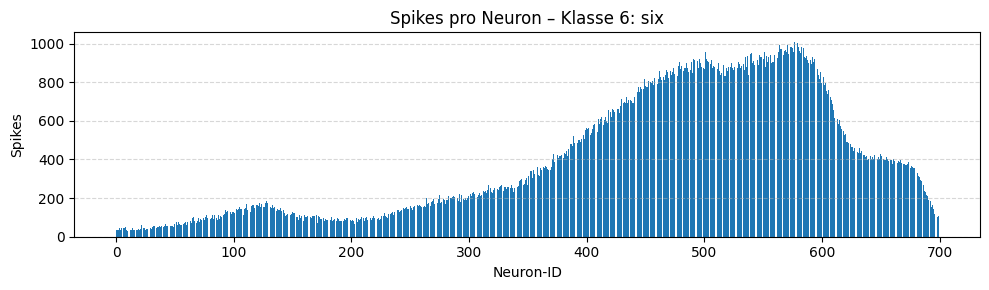

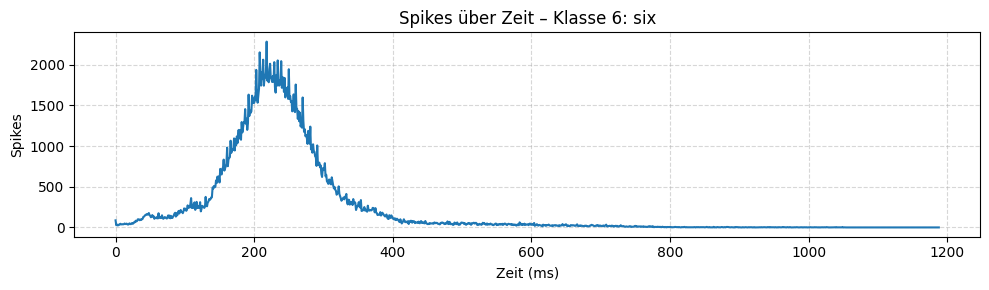

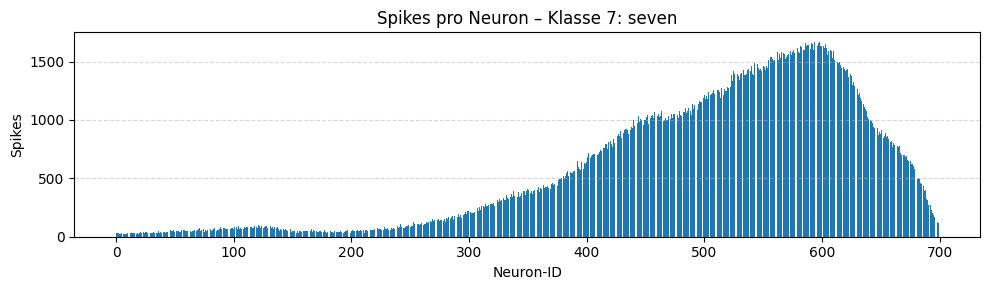

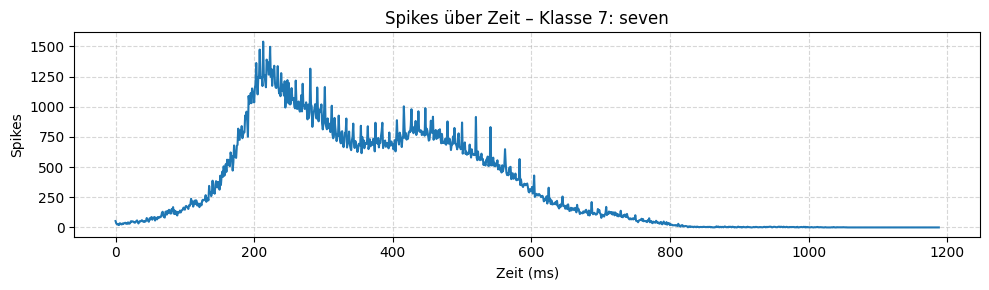

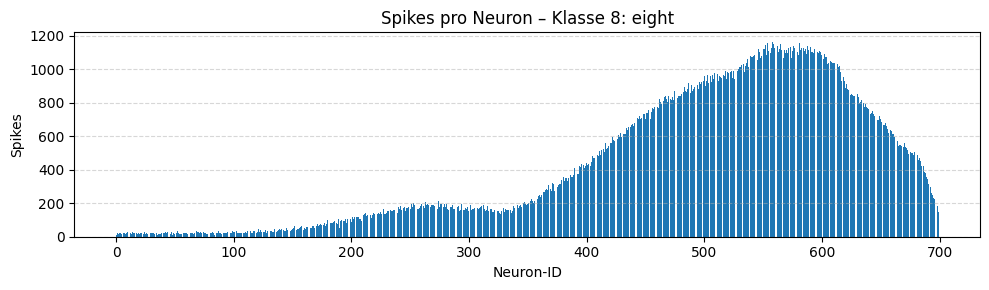

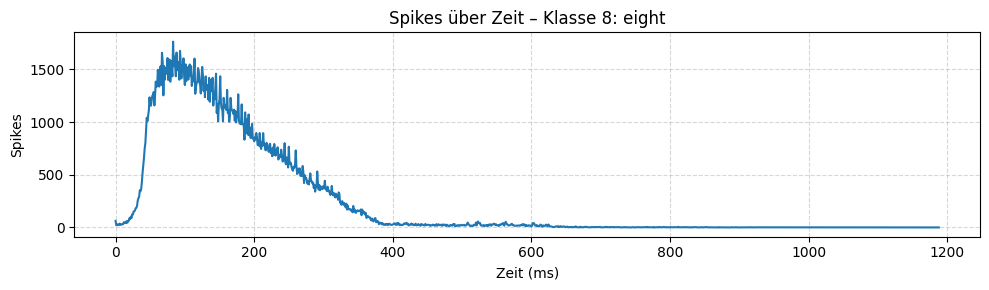

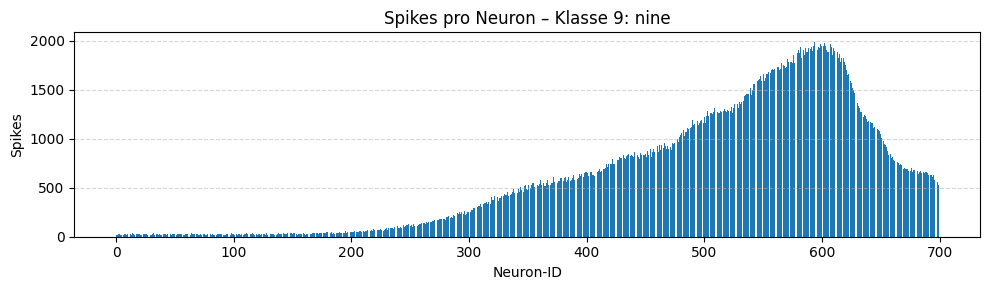

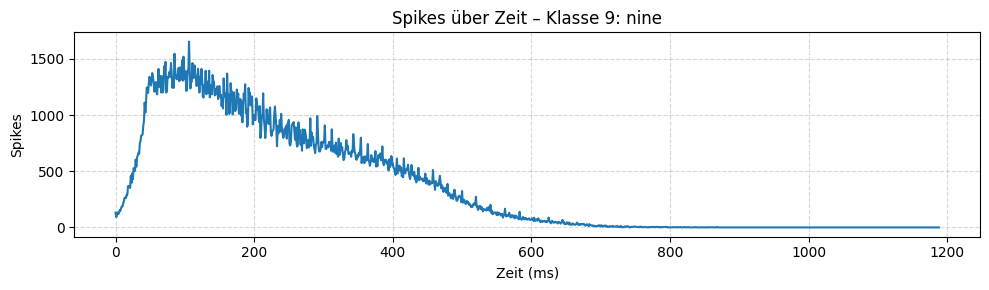

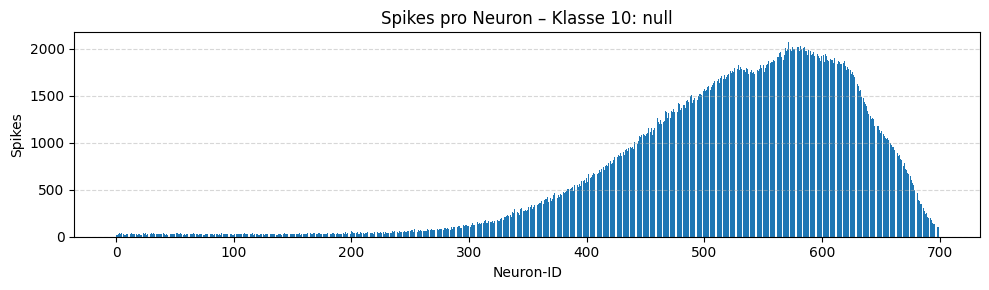

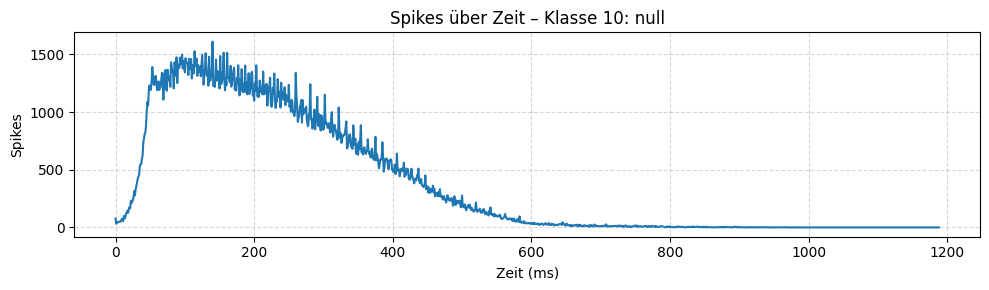

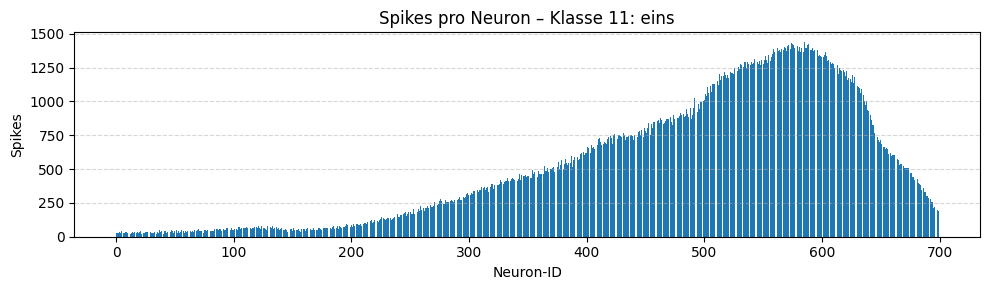

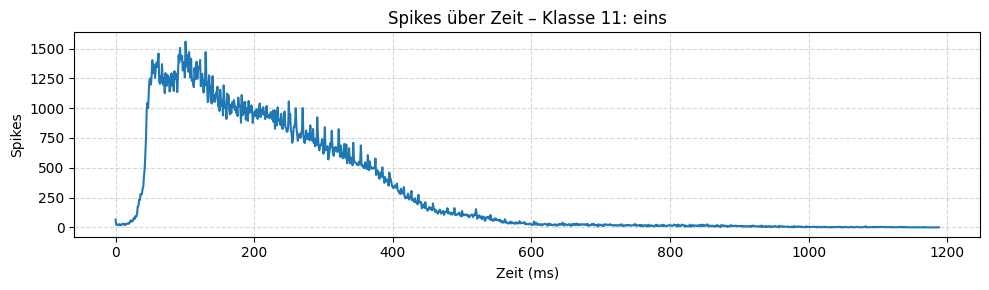

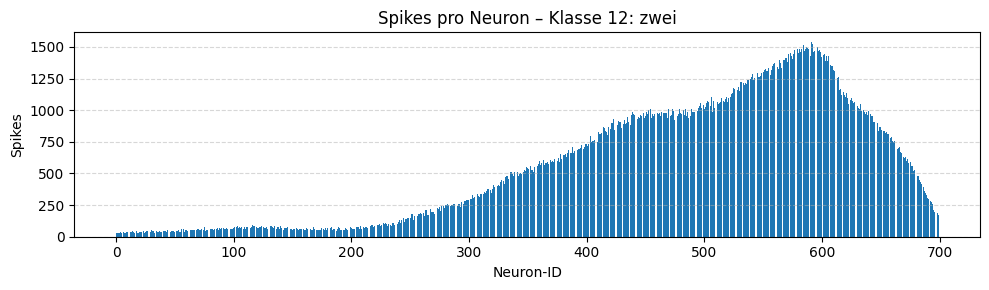

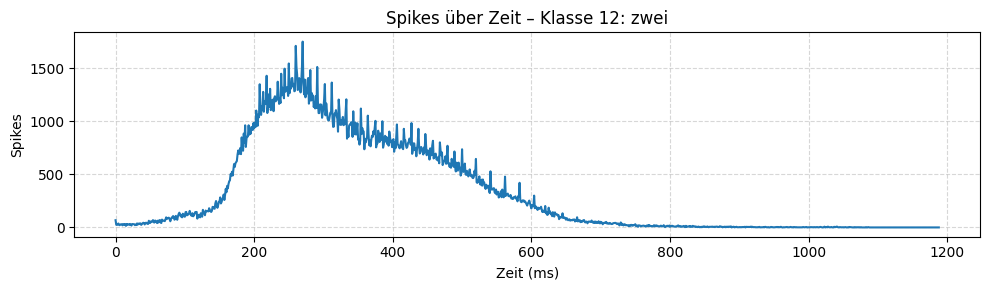

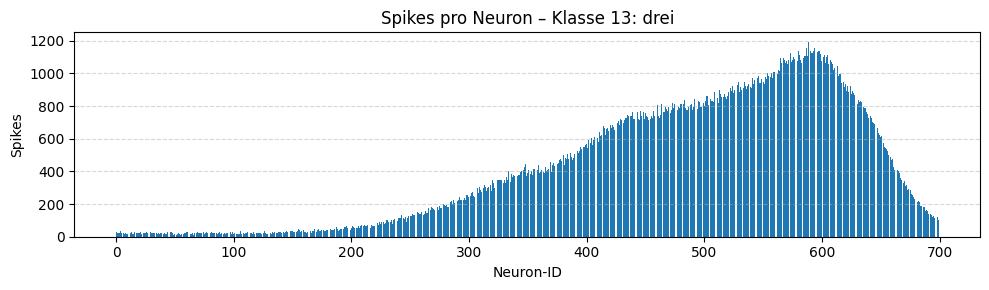

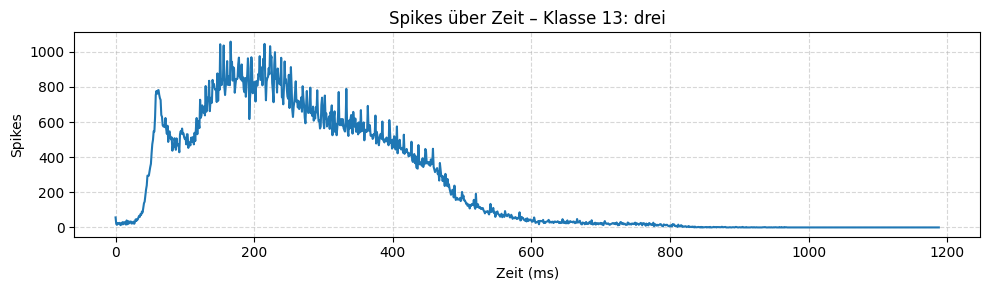

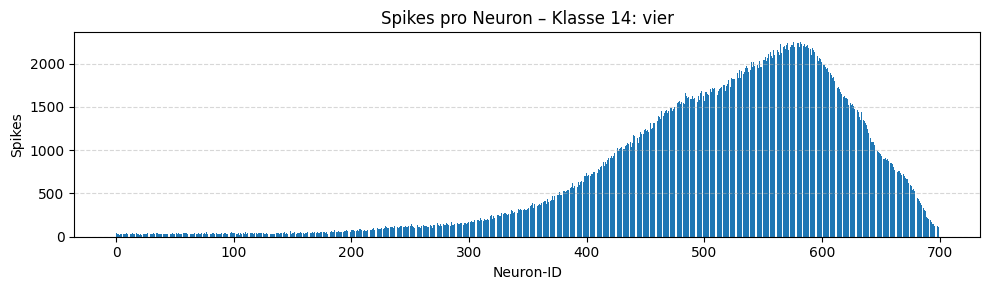

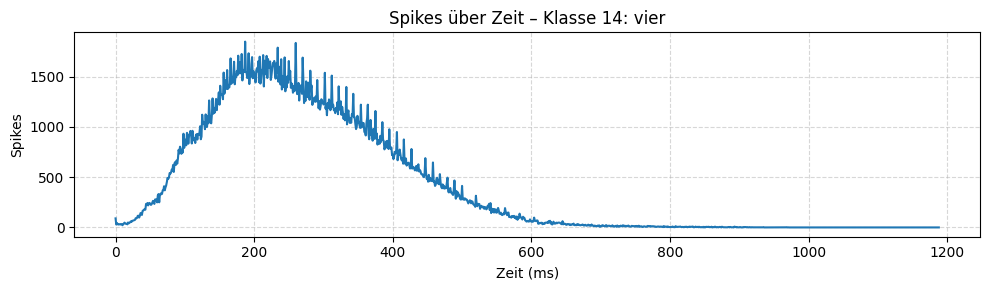

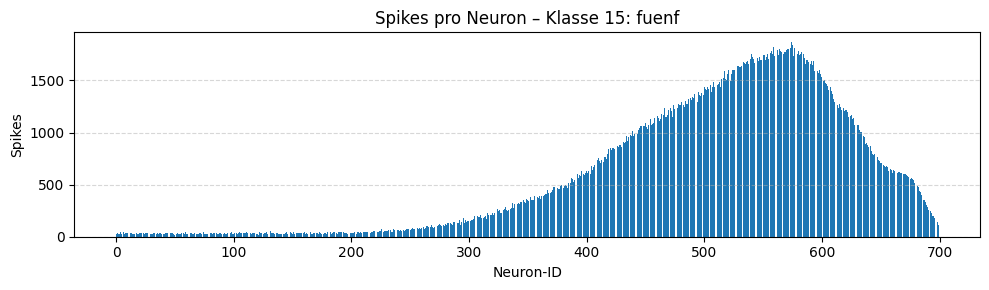

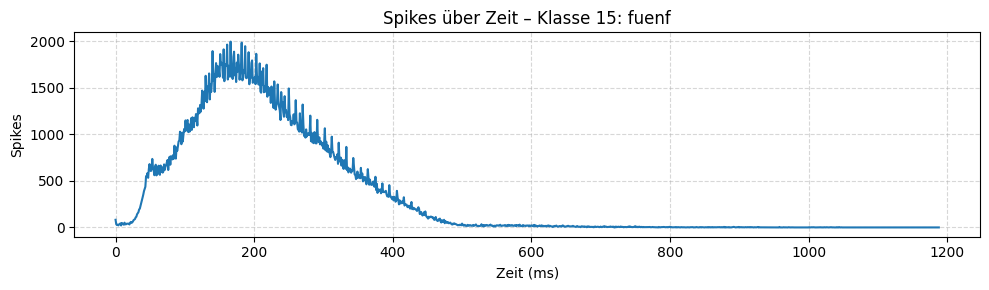

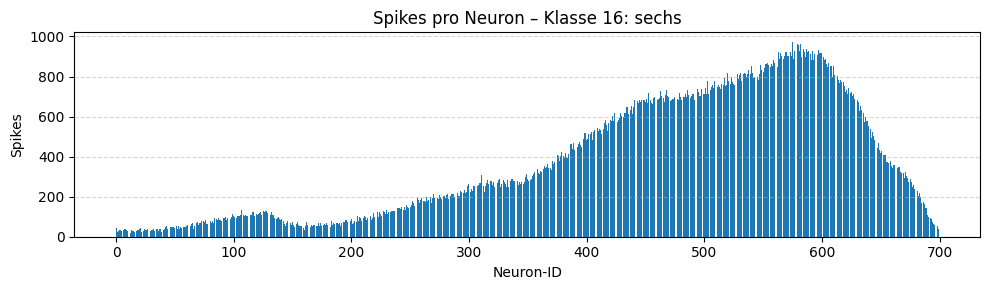

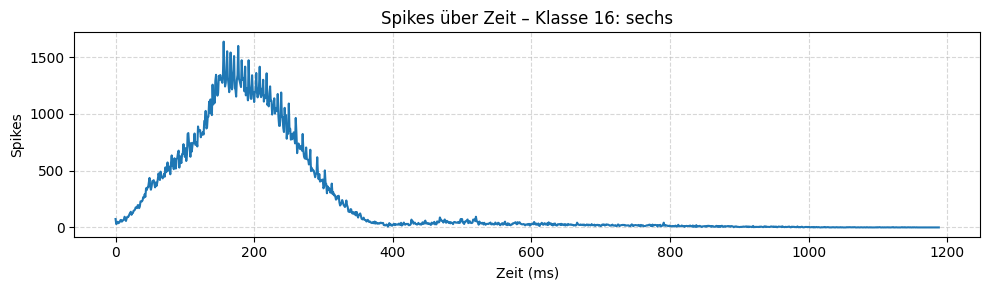

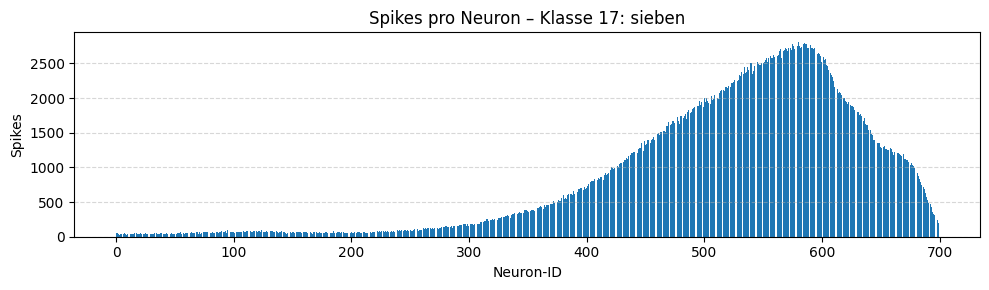

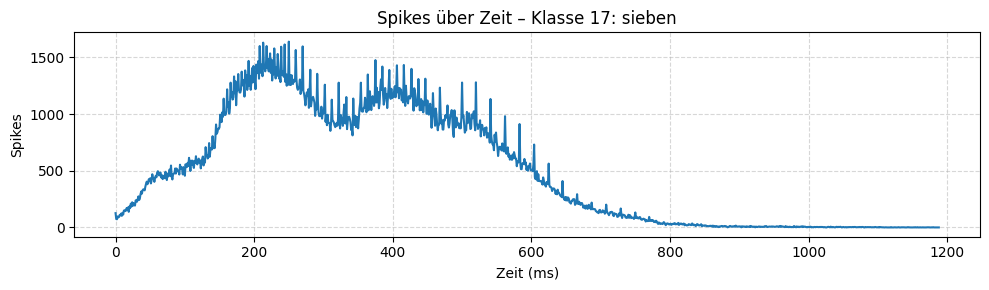

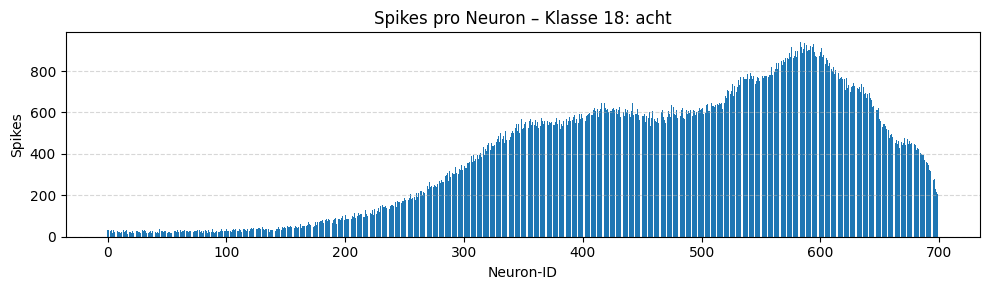

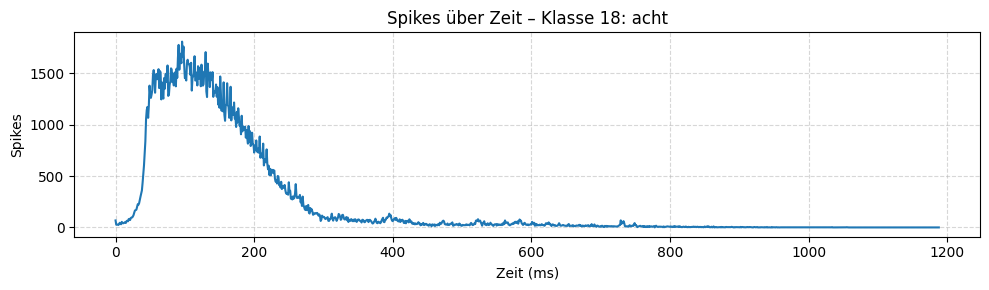

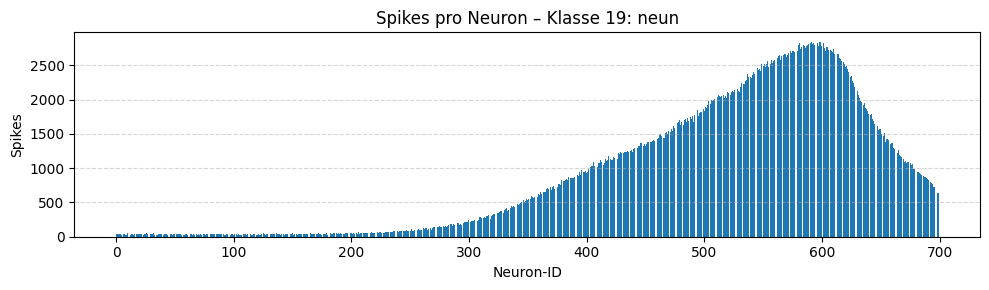

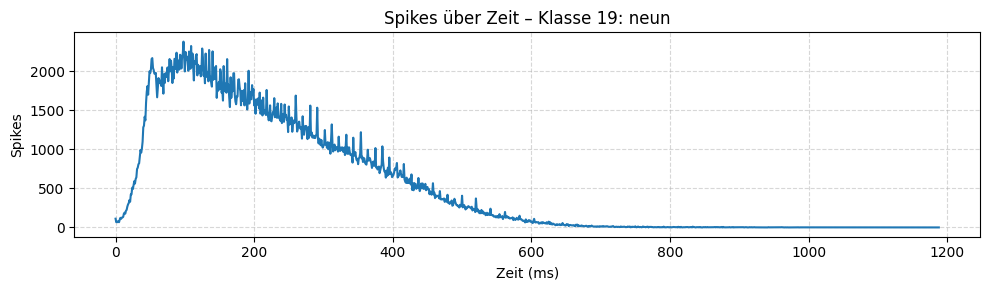

In [18]:
from tonic.datasets import SHD
dataset = SHD(save_to="./data", train=True, transform=None)

summed_tensors = analyze_shd_all_classes(dataset, N=1000)


In [19]:
from tonic import transforms

sensor_size = tonic.datasets.SHD.sensor_size  # = (700,)
transform = transforms.ToFrame(sensor_size=sensor_size, time_window=1_000)  # 1 ms-Binning


In [20]:
trainset = tonic.datasets.SHD(save_to="./data", train=True, transform=transform)

In [21]:
from torch.utils.data import DataLoader
from tonic import MemoryCachedDataset


cached_trainset = MemoryCachedDataset(trainset)
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [22]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [23]:
%timeit -o -r 10 load_sample_batched()

797 μs ± 105 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


<TimeitResult : 797 μs ± 105 μs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)>

In [24]:
pip install umap-learn ipywidgets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install umap-learn ipywidgets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tonic

# --- 1. Auf bereits geladenen Datensatz zugreifen und filtern ---
# HINWEIS: Dieser Code geht davon aus, dass die Variable 'trainset' 
# aus der Zelle in deiner explore_shd.ipynb Datei noch existiert.
print("Filtere bereits geladenen SHD-Datensatz...")
english_digit_indices = [i for i, (events, label) in enumerate(trainset) if label < 10]

N_SAMPLES = 1000
subset_indices = shuffle(english_digit_indices, random_state=42)[:N_SAMPLES]

# --- 2. Daten umwandeln (Densify) ---
print(f"Verarbeite {N_SAMPLES} gefilterte Samples...")
dense_data_filtered = []
labels_filtered = []
sensor_size = trainset.sensor_size[0]
for i in subset_indices:
    events, label = trainset[i]
    spike_counts = np.bincount(events['x'], minlength=sensor_size)
    dense_data_filtered.append(spike_counts)
    labels_filtered.append(label)

dense_data_filtered = np.array(dense_data_filtered)
labels_filtered = np.array(labels_filtered)

# --- 3. Skalieren ---
scaled_data = StandardScaler().fit_transform(dense_data_filtered)

# --- 4. Dimensionen mit PCA reduzieren ---
print("Reduziere Dimensionen mit PCA von 700 auf 50...")
pca = PCA(n_components=50)
pca_data = pca.fit_transform(scaled_data)
print(f"✅ Datenvorbereitung abgeschlossen. Neue Datenform: {pca_data.shape}")
print("Die Variablen 'pca_data' und 'labels_filtered' sind jetzt bereit.")

Filtere bereits geladenen SHD-Datensatz...
Verarbeite 1000 gefilterte Samples...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# --- 1. PCA durchführen ---
# (Stelle sicher, dass 'scaled_data' und 'labels_filtered' existieren)

print("Führe PCA mit 3 Komponenten durch...")
# Wir reduzieren die 700 Dimensionen auf die 3 wichtigsten Hauptkomponenten.
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)
print("✅ PCA abgeschlossen.")


# --- 2. Interaktive 3D-PCA-Plot-Funktion ---

# Mapping von Label-Index zu Wort bleibt gleich
index_to_word = {
    0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
    5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"
}

def plot_interactive_pca_3d(elev, azim):
    # 3D-Plot erstellen
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Setze den Blickwinkel basierend auf den Slider-Werten
    ax.view_init(elev=elev, azim=azim)
    
    scatter = ax.scatter(
        principal_components[:, 0], 
        principal_components[:, 1], 
        principal_components[:, 2],
        c=labels_filtered, 
        cmap='Spectral', 
        s=15,
        alpha=0.8
    )
    
    ax.set_title(f"3D PCA Visualisierung", fontsize=16)
    ax.set_xlabel("Hauptkomponente 1")
    ax.set_ylabel("Hauptkomponente 2")
    ax.set_zlabel("Hauptkomponente 3")
    
    unique_labels = np.unique(labels_filtered)
    legend_labels = [index_to_word.get(i, str(i)) for i in unique_labels]
    
    ax.legend(handles=scatter.legend_elements(num=len(unique_labels))[0], labels=legend_labels, title="Gesprochene Ziffern")
    plt.show()

# --- 3. Slider für den Blickwinkel erstellen ---

interact(
    plot_interactive_pca_3d, 
    elev=widgets.IntSlider(min=-90, max=90, step=10, value=20, description='Höhe (Elev):'), 
    azim=widgets.IntSlider(min=-180, max=180, step=10, value=-60, description='Rotation (Azim):')
);

Führe PCA mit 3 Komponenten durch...
✅ PCA abgeschlossen.


interactive(children=(IntSlider(value=20, description='Höhe (Elev):', max=90, min=-90, step=10), IntSlider(val…

Erklärte Varianz pro Hauptkomponente:


,Hauptkomponente,Erklärte Varianz,Kumulative Varianz
0,1,22.33%,22.33%
1,2,11.65%,33.98%
2,3,8.05%,42.03%
3,4,6.37%,48.40%
4,5,4.57%,52.97%
5,6,2.60%,55.57%
6,7,1.53%,57.09%
7,8,1.43%,58.53%
8,9,0.92%,59.45%
9,10,0.61%,60.06%


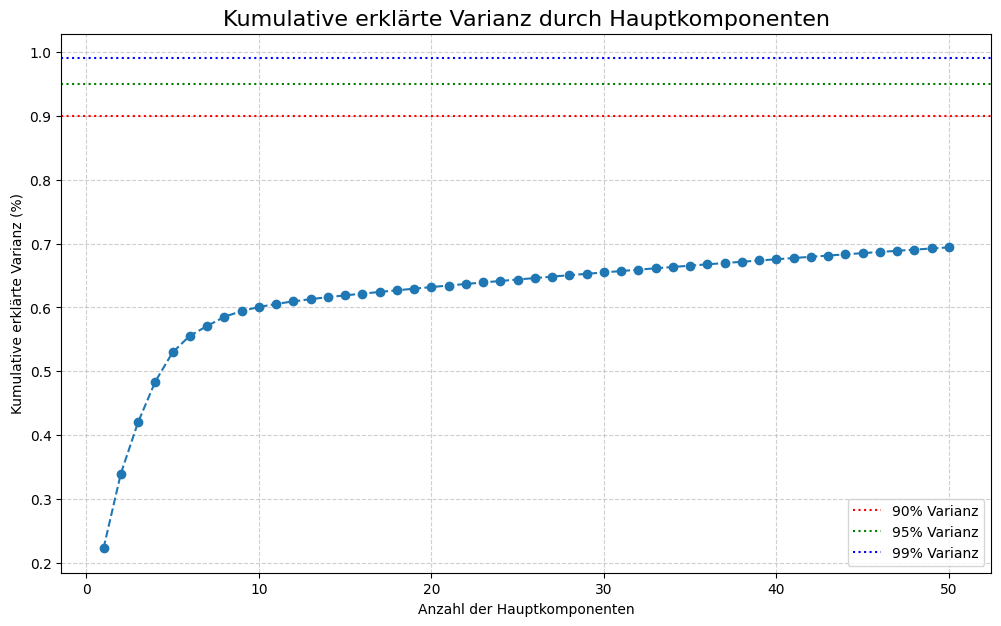

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- 1. PCA für eine größere Anzahl an Komponenten durchführen ---
# (Stelle sicher, dass 'scaled_data' existiert)

# Wir wählen hier 50 Komponenten, um einen guten Überblick zu bekommen.
n_pca_components = 50
pca = PCA(n_components=n_pca_components)
pca.fit(scaled_data)


# --- 2. Tabelle der erklärten Varianz erstellen ---

# Varianz pro Komponente
explained_variance = pca.explained_variance_ratio_

# Kumulative (aufsummierte) Varianz
cumulative_variance = np.cumsum(explained_variance)

# DataFrame für eine saubere Tabellendarstellung
variance_df = pd.DataFrame({
    "Hauptkomponente": np.arange(1, n_pca_components + 1),
    "Erklärte Varianz": explained_variance,
    "Kumulative Varianz": cumulative_variance
})

# Formatiere die Ausgabe als Prozentwerte für bessere Lesbarkeit
styled_df = variance_df.style.format({
    "Erklärte Varianz": "{:.2%}",
    "Kumulative Varianz": "{:.2%}"
})

print("Erklärte Varianz pro Hauptkomponente:")
display(styled_df)


# --- 3. Kumulative Varianz plotten (Scree Plot) ---

plt.figure(figsize=(12, 7))
plt.plot(variance_df["Hauptkomponente"], variance_df["Kumulative Varianz"], marker='o', linestyle='--')
plt.title("Kumulative erklärte Varianz durch Hauptkomponenten", fontsize=16)
plt.xlabel("Anzahl der Hauptkomponenten")
plt.ylabel("Kumulative erklärte Varianz (%)")
plt.grid(True, linestyle='--', alpha=0.6)

# Referenzlinien für gängige Schwellenwerte
plt.axhline(y=0.90, color='r', linestyle=':', label='90% Varianz')
plt.axhline(y=0.95, color='g', linestyle=':', label='95% Varianz')
plt.axhline(y=0.99, color='b', linestyle=':', label='99% Varianz')

plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# --- 1. t-SNE-Funktion für die interaktive Visualisierung ---
# (Stelle sicher, dass 'scaled_data' und 'labels_filtered' aus den vorherigen Zellen existieren)

# Mapping von Label-Index zu Wort
index_to_word = {
    0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
    5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"
}

def plot_interactive_tsne_3d(perplexity, elev, azim):
    print("Führe t-SNE mit 3 Komponenten und Perplexität=" + str(perplexity) + " durch...")
    # Wir reduzieren die 700 Dimensionen auf 3 t-SNE-Komponenten.
    tsne = TSNE(
        n_components=3, 
        perplexity=perplexity, 
        random_state=42, 
        init='pca', 
        learning_rate='auto'
    )
    embedding = tsne.fit_transform(scaled_data)
    print("✅ t-SNE abgeschlossen.")
    
    # --- 2. 3D-Plot erstellen ---
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Setze den Blickwinkel
    ax.view_init(elev=elev, azim=azim)
    
    scatter = ax.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        embedding[:, 2],
        c=labels_filtered, 
        cmap='Spectral', 
        s=15,
        alpha=0.8
    )
    
    ax.set_title(f"3D t-SNE Visualisierung (Perplexität: {perplexity})", fontsize=16)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")
    
    unique_labels = np.unique(labels_filtered)
    legend_labels = [index_to_word.get(i, str(i)) for i in unique_labels]
    
    ax.legend(handles=scatter.legend_elements(num=len(unique_labels))[0], labels=legend_labels, title="Gesprochene Ziffern")
    plt.show()

# --- 3. Slider erstellen ---

interact(
    plot_interactive_tsne_3d, 
    perplexity=widgets.IntSlider(min=5, max=50, step=5, value=30, description='Perplexität:'), 
    elev=widgets.IntSlider(min=-90, max=90, step=10, value=20, description='Höhe (Elev):'), 
    azim=widgets.IntSlider(min=-180, max=180, step=10, value=-60, description='Rotation (Azim):')
);

interactive(children=(IntSlider(value=30, description='Perplexität:', max=50, min=5, step=5), IntSlider(value=…

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Bedienelemente (Widgets) erstellen ---

# Mapping von Label-Index zu Wort
index_to_word = {
    0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
    5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"
}

# Slider, die wir schon kennen
perplexity_slider = widgets.IntSlider(min=5, max=50, step=5, value=30, description='Perplexität:')
elev_slider = widgets.IntSlider(min=-90, max=90, step=10, value=20, description='Höhe:')
azim_slider = widgets.IntSlider(min=-180, max=180, step=10, value=-60, description='Rotation:')

# Checkboxen für jede Ziffer (0-9) erstellen
checkboxes = {
    f"show_{label}": widgets.Checkbox(value=True, description=word) 
    for label, word in index_to_word.items()
}


# --- 2. Funktion für die interaktive Visualisierung ---

# Diese Funktion wird nun von allen Widgets gemeinsam aufgerufen
def plot_with_checkboxes(perplexity, elev, azim, **show_labels):
    # Führe die rechenintensive t-SNE-Analyse nur aus, wenn die Perplexität geändert wird.
    # Wir speichern das Ergebnis zwischen, um die Rotation flüssiger zu machen.
    if perplexity not in plot_with_checkboxes.cache:
        print(f"Berechne t-SNE mit Perplexität={perplexity}...")
        tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
        plot_with_checkboxes.cache[perplexity] = tsne.fit_transform(scaled_data)
        print("✅ t-SNE abgeschlossen.")
    
    embedding = plot_with_checkboxes.cache[perplexity]
    
    # --- Filtern basierend auf den Checkboxen ---
    labels_to_show = [int(key.split('_')[1]) for key, value in show_labels.items() if value]
    mask = np.isin(labels_filtered, labels_to_show)
    
    # --- 3D-Plot erstellen ---
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    
    scatter = ax.scatter(
        embedding[mask, 0], 
        embedding[mask, 1], 
        embedding[mask, 2],
        c=labels_filtered[mask], 
        cmap='Spectral', 
        s=15,
        alpha=0.8
    )
    
    ax.set_title(f"3D t-SNE Visualisierung", fontsize=16)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")
    
    # Legende nur für die sichtbaren Klassen erstellen
    unique_labels_shown = np.unique(labels_filtered[mask])
    legend_labels = [index_to_word.get(i, str(i)) for i in unique_labels_shown]
    if legend_labels: # Nur anzeigen, wenn etwas ausgewählt ist
        ax.legend(handles=scatter.legend_elements(num=len(unique_labels_shown))[0], labels=legend_labels, title="Angezeigte Ziffern")
    
    plt.show()

# Initialisiere einen Cache für die Funktion
plot_with_checkboxes.cache = {}


# --- 3. Layout und Interaktion verbinden ---

# Alle Widgets in einem Dictionary zusammenfassen
all_controls = {
    'perplexity': perplexity_slider,
    'elev': elev_slider,
    'azim': azim_slider,
    **checkboxes  # Fügt alle Checkboxen hinzu
}

# Anordnung der Bedienelemente
checkbox_grid = HBox(list(checkboxes.values()))
slider_grid = HBox([perplexity_slider, elev_slider, azim_slider])
ui = VBox([checkbox_grid, slider_grid])

# Die Ausgabe mit der Funktion und den Steuerelementen verbinden
out = interactive_output(plot_with_checkboxes, all_controls)

# Das interaktive Dashboard anzeigen
display(ui, out)

Output()

In [31]:
pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [32]:
import skdim
from sklearn.preprocessing import StandardScaler

# --- Verwende die gefilterten, aber NICHT skalierten Daten ---
# Die meisten Schätzer funktionieren am besten mit den Original-Distanzen.
# (Stelle sicher, dass 'dense_data_filtered' aus den vorherigen Zellen existiert)

print("Schätze die intrinsische Dimension mit TwoNN...")

# Erstelle den Schätzer
twonn = skdim.id.TwoNN()

# Führe die Schätzung durch
# fit_transform gibt direkt die geschätzte Dimension zurück
intrinsic_dimension = twonn.fit_transform(dense_data_filtered)

print(f"\n✅ Geschätzte intrinsische Dimension des SHD-Daten-Manifolds: {intrinsic_dimension:.2f}")

Schätze die intrinsische Dimension mit TwoNN...

✅ Geschätzte intrinsische Dimension des SHD-Daten-Manifolds: 31.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Isomap-Funktion für die interaktive Visualisierung ---
# (Stelle sicher, dass 'scaled_data' und 'labels_filtered' existieren)

# Mapping von Label-Index zu Wort
index_to_word = {
    0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
    5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"
}

def plot_interactive_isomap_3d(n_neighbors, elev, azim):
    print(f"Führe Isomap mit n_neighbors = {n_neighbors} durch...")
    # Wir reduzieren die 700 Dimensionen auf 3 Isomap-Komponenten.
    # n_jobs=-1 nutzt alle verfügbaren CPU-Kerne zur Beschleunigung.
    isomap = Isomap(
        n_components=3, 
        n_neighbors=n_neighbors,
        n_jobs=-1
    )
    embedding = isomap.fit_transform(scaled_data)
    print("✅ Isomap abgeschlossen.")
    
    # --- 2. 3D-Plot erstellen ---
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Setze den Blickwinkel
    ax.view_init(elev=elev, azim=azim)
    
    scatter = ax.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        embedding[:, 2],
        c=labels_filtered, 
        cmap='Spectral', 
        s=15,
        alpha=0.8
    )
    
    ax.set_title(f"3D Isomap Visualisierung (Nachbarn: {n_neighbors})", fontsize=16)
    ax.set_xlabel("Isomap Dimension 1")
    ax.set_ylabel("Isomap Dimension 2")
    ax.set_zlabel("Isomap Dimension 3")
    
    unique_labels = np.unique(labels_filtered)
    legend_labels = [index_to_word.get(i, str(i)) for i in unique_labels]
    
    ax.legend(handles=scatter.legend_elements(num=len(unique_labels))[0], labels=legend_labels, title="Gesprochene Ziffern")
    plt.show()

# --- 3. Slider erstellen ---

interact(
    plot_interactive_isomap_3d, 
    n_neighbors=widgets.IntSlider(min=5, max=50, step=5, value=15, description='Nachbarn:'), 
    elev=widgets.IntSlider(min=-90, max=90, step=10, value=20, description='Höhe (Elev):'), 
    azim=widgets.IntSlider(min=-180, max=180, step=10, value=-60, description='Rotation (Azim):')
);

interactive(children=(IntSlider(value=15, description='Nachbarn:', max=50, min=5, step=5), IntSlider(value=20,…